Library Imports

In [23]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE # imbalanced class data fix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


File Loading

In [24]:
# file pathways
drive_base_path = '/content/drive/My Drive'
features_3_sec_path = f'{drive_base_path}/Features_3_sec.csv' # 10 datapoints of 3 second long mean and variance of each song
features_30_sec_path = f'{drive_base_path}/Features_30_sec.csv' # 30 second long mean and variance of each song

# dataset loading
data = pd.read_csv(features_3_sec_path) # smaller file: `features_30_sec_path`... has 65% success rate
print(f"Dataset shape before cleaning: {data.shape}")



Dataset shape before cleaning: (9990, 60)


Dataset Manipulation/Cleaning

In [25]:

# Clean datset
print("Checking for nulls")
if data.isnull().values.any(): #find null values
    print(f"Found missing values")
    data = data.dropna()# remove rows with missing values
    print(f"After cleaning -- dataset shape: {data.shape}")
else:
    print("No missing values found")
    print(f"No cleaning neccessary -- dataset shape: {data.shape}")

# CSV features and labels separation
print("Separating features and labels")
features = data.drop(columns=['filename', 'label']) #unnecessary columns drop
labels = data['label'] # keep the genre labels
print(f"number of features: {features.shape[1]}")
print(f"number of labels: {len(labels)}")

# converting labels (genres) as numbers
print("Encoding genre labels into numeric values")
label_encoder = LabelEncoder() # conversion
encoded_labels = label_encoder.fit_transform(labels) # encode labels
unique_labels = label_encoder.classes_ # list of unique genres
print(f"Unique genres: {list(unique_labels)}")




Checking for nulls
No missing values found
No cleaning neccessary -- dataset shape: (9990, 60)
Separating features and labels
number of features: 58
number of labels: 9990
Encoding genre labels into numeric values
Unique genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Dataset Splitting and Balancing

In [26]:

# training and testing set splitting
print("Splitting data into training and testing")
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# standarize
print("standarize with scalar function")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)# fit and transform training
X_test_scaled = scaler.transform(X_test) # only transform testing data, not training

# imbalance class handing
print("Balancing classes")
smote = SMOTE(random_state=42) # SMOTE object
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
print(f"New training set size after SMOTE: {X_train_balanced.shape[0]} samples")


Splitting data into training and testing
Training set size: 7992 samples
Testing set size: 1998 samples
standarize with scalar function
Balancing classes
New training set size after SMOTE: 8200 samples


SVM Traiing and Evaluation

In [27]:

# SVM model training
print("Training SVM classifier")
# gradient needed ?
svm_classifier = SVC(kernel='rbf', C=1,gamma='scale', class_weight='balanced', random_state=42)
svm_classifier.fit(X_train_balanced, y_train_balanced) # fitting model to training data
print("SVM model training complete")

# Evaluate the model
print("Evaluating the SVM model on test data")
y_pred = svm_classifier.predict(X_test_scaled) # predict on test dataset
accuracy = accuracy_score(y_test, y_pred) #accuracy score
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=unique_labels))


Training SVM classifier
SVM model training complete
Evaluating the SVM model on test data
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.88      0.87       208
   classical       0.85      0.98      0.91       203
     country       0.80      0.82      0.81       186
       disco       0.80      0.78      0.79       199
      hiphop       0.95      0.87      0.91       218
        jazz       0.86      0.84      0.85       192
       metal       0.90      0.94      0.92       204
         pop       0.90      0.92      0.91       180
      reggae       0.87      0.87      0.87       211
        rock       0.80      0.71      0.75       197

    accuracy                           0.86      1998
   macro avg       0.86      0.86      0.86      1998
weighted avg       0.86      0.86      0.86      1998



Vizualization

Performing PCA for visualization


<ipython-input-28-b45e10637a1f>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


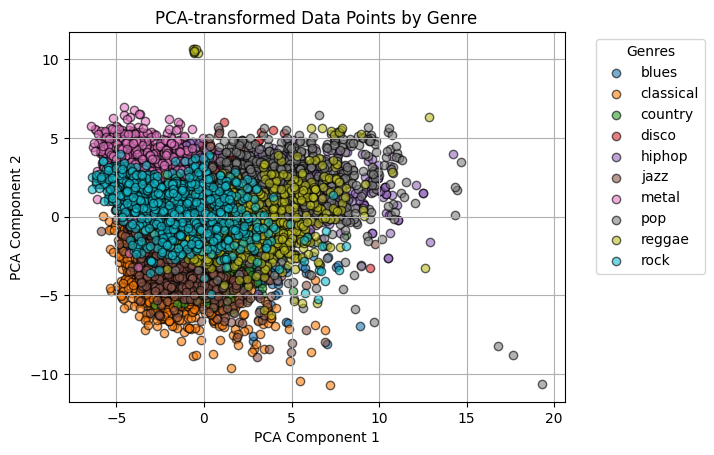

In [28]:

# reduce dim so we can visualize
print("Performing PCA for visualization")
pca = PCA(n_components=2)  # Reduce to 2 dimensions for easier visualization
X_train_pca = pca.fit_transform(X_train_balanced)  # Fit PCA on training data

# graph show
unique_genres = unique_labels
num_classes = len(unique_genres)
colors = plt.cm.get_cmap('tab10', num_classes)

for genre_index, genre_name in enumerate(unique_genres):
    genre_indices = [i for i, label in enumerate(y_train_balanced) if label == genre_index]
    genre_points = X_train_pca[genre_indices]  # PCA points for the current genre
    plt.scatter(genre_points[:, 0], genre_points[:, 1], label=genre_name, color=colors(genre_index), edgecolor='k', alpha=0.6)


plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA-transformed Data Points by Genre")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

Two Genre Comparison

Comparing: metal and classical


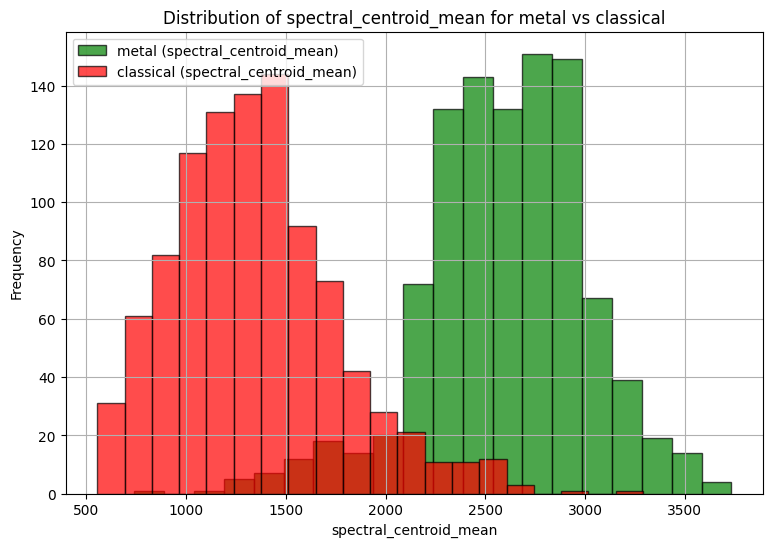

In [29]:
genre_1 = 'metal' # first genre to compare
genre_2 = 'classical' # second

genre_compare_1_data = data[data['label'] == genre_1]
genre_compare_2_data = data[data['label'] == genre_2]

print(f"Comparing: {genre_1} and {genre_2}")
feature = 'spectral_centroid_mean' # comparison feature

# histogram
plt.figure(figsize=(9, 6))
plt.hist(genre_compare_1_data[feature], bins=20, alpha=0.7, label=f"{genre_1} ({feature})", color='green', edgecolor='black')
plt.hist(genre_compare_2_data[feature], bins=20, alpha=0.7, label=f"{genre_2} ({feature})", color='red', edgecolor='black')
plt.title(f"Distribution of {feature} for {genre_1} vs {genre_2}")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()



Metal and Classical PCA Comparison Vizual

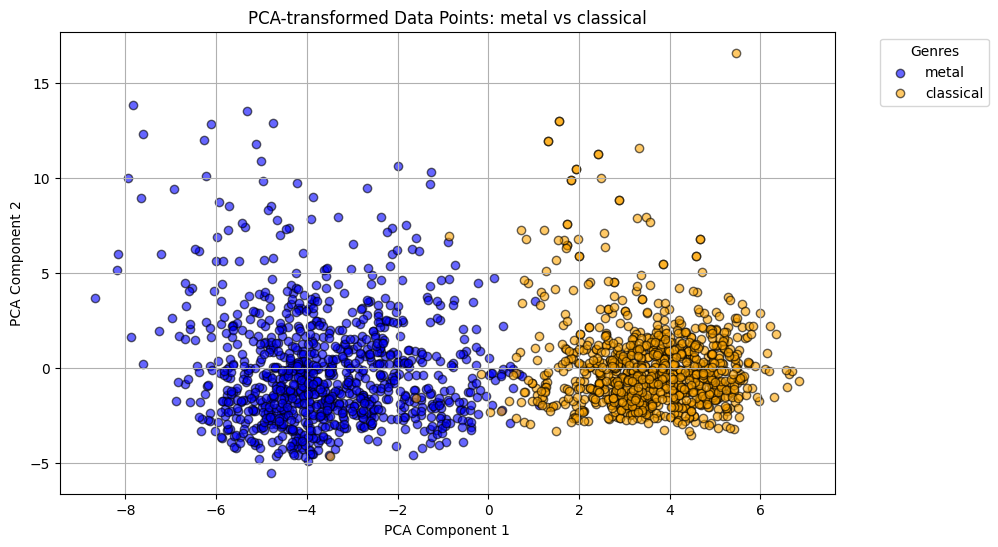

In [30]:
genre_1 = 'metal' # first genre to compare
genre_2 = 'classical' # second

# data grab for both genres
filtered_data = data[(data['label'] == genre_1) | (data['label'] == genre_2)]
filtered_labels = filtered_data['label']
filtered_features = filtered_data.drop(columns=['filename', 'label'])


filtered_label_encoded = LabelEncoder().fit_transform(filtered_labels) # encode
filtered_features_scaled = StandardScaler().fit_transform(filtered_features) # standarize


pca = PCA(n_components=2)  # Reduce to 2 dimensions for easier visualization
filtered_features_pca = pca.fit_transform(filtered_features_scaled)



plt.figure(figsize=(10, 6))
colors = ['blue', 'orange']  # two genres colors for plot
labels = [genre_1, genre_2]  # legend labels

for genre_index, genre_name in enumerate(labels):
    genre_indices = [i for i, label in enumerate(filtered_label_encoded) if label == genre_index]
    genre_points = filtered_features_pca[genre_indices]  # PCA points for the current genre
    plt.scatter(genre_points[:, 0], genre_points[:, 1], label=genre_name, color=colors[genre_index], edgecolor='k', alpha=0.6)


plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"PCA-transformed Data Points: {genre_1} vs {genre_2}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


Blues and Reggae PCA Comparison Vizual

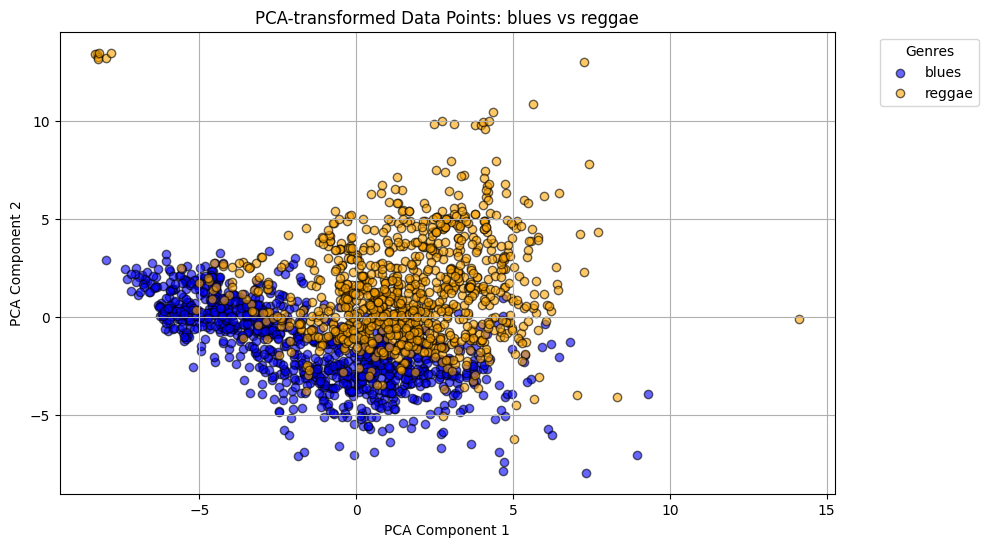

In [31]:
genre_1 = 'blues' # first genre to compare
genre_2 = 'reggae' # second

# data grab for both genres
filtered_data = data[(data['label'] == genre_1) | (data['label'] == genre_2)]
filtered_labels = filtered_data['label']
filtered_features = filtered_data.drop(columns=['filename', 'label'])


filtered_label_encoded = LabelEncoder().fit_transform(filtered_labels) # encode
filtered_features_scaled = StandardScaler().fit_transform(filtered_features) # standarize


pca = PCA(n_components=2)  # Reduce to 2 dimensions for easier visualization
filtered_features_pca = pca.fit_transform(filtered_features_scaled)



plt.figure(figsize=(10, 6))
colors = ['blue', 'orange']  # two genres colors for plot
labels = [genre_1, genre_2]  # legend labels

for genre_index, genre_name in enumerate(labels):
    genre_indices = [i for i, label in enumerate(filtered_label_encoded) if label == genre_index]
    genre_points = filtered_features_pca[genre_indices]  # PCA points for the current genre
    plt.scatter(genre_points[:, 0], genre_points[:, 1], label=genre_name, color=colors[genre_index], edgecolor='k', alpha=0.6)


plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"PCA-transformed Data Points: {genre_1} vs {genre_2}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

Confusion Matrix

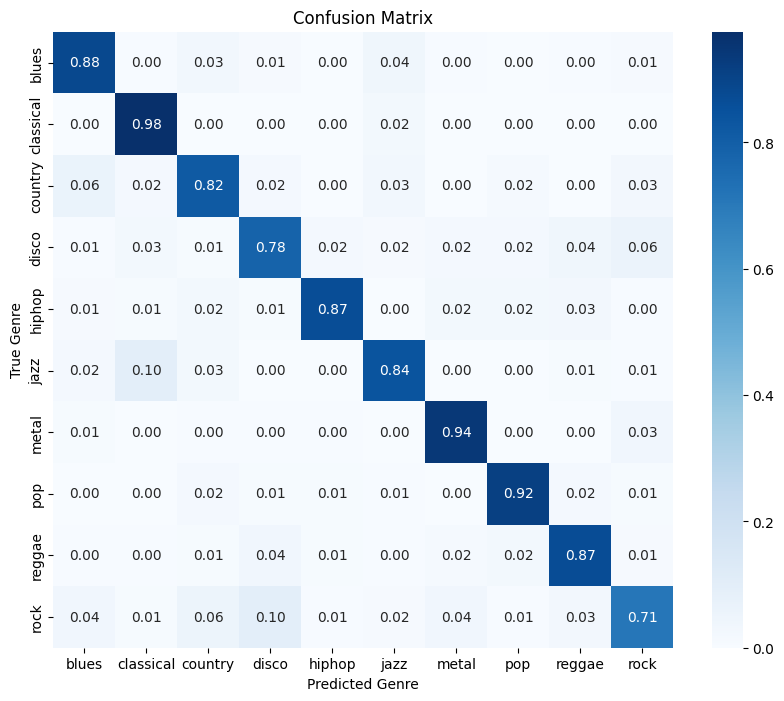

In [32]:

conf_matrix = confusion_matrix(y_test, y_pred) #produce confusion matrix
conf_matrix_normalized = conf_matrix.astype(float) / conf_matrix.sum(axis=1)[:, None] #normize to percents instead of count


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()



Misclassification Analysis

In [33]:
misclassification_rates = []
for i in range(len(unique_labels)):
    misclassification_rate = 1 - conf_matrix_normalized[i, i]  # 1 - diagonal values
    misclassification_rates.append((unique_labels[i], misclassification_rate))
# print(misclassification_rates)

misclassification_rates_sorted = sorted(misclassification_rates, key=lambda x: x[1], reverse=True) #descenting order
print("\nHighest misclassification rates:")
for genre, rate in misclassification_rates_sorted:
    print(f"{genre}: {rate:.2f}")



Highest misclassification rates:
rock: 0.29
disco: 0.22
country: 0.18
jazz: 0.16
hiphop: 0.13
reggae: 0.13
blues: 0.12
pop: 0.08
metal: 0.06
classical: 0.02
